When benchmarking you **MUST**

1. close all applications
2. close docker
3. close all but this Web windows
4. all pen editors other than jupyter-lab (this notebook)


In [1]:
import os
from cloudmesh.common.Shell import Shell
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
from tqdm.notebook import tqdm
from cloudmesh.common.util import readfile
from cloudmesh.common.util import writefile
from cloudmesh.common.StopWatch import StopWatch 
from cloudmesh.common.systeminfo import systeminfo
import ipywidgets as widgets

sns.set_theme(style="whitegrid")
info = systeminfo()

In [2]:

user = info["user"] 
node = info["uname.node"]
processors = 4

In [3]:
# Parameters
user = "gregor"
node = "i5"
processors = 6


In [4]:
p = widgets.IntSlider(
    value=processors,
    min=2,
    max=64,
    step=1,
    description='Processors:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
u = widgets.Text(value=user, placeholder='The user name', description='User:', disabled=False)
n = widgets.Text(value=node, placeholder='The computer name', description='Computer:', disabled=False)

display(p)
display(u)
display(n)

IntSlider(value=6, continuous_update=False, description='Processors:', max=64, min=2)

Text(value='gregor', description='User:', placeholder='The user name')

Text(value='i5', description='Computer:', placeholder='The computer name')

In [5]:
processors = p.value
user = u.value
node = n.value
print (processors, user, node)

6 gregor i5


In [6]:

experiments = 10
maximum = 1024 * 100000
intervals = 10

In [7]:
label = f"{user}-{node}-{processors}"
output = f"benchmark/{user}"

delta = int(maximum / intervals)

totals = [64] + list(range(0,maximum, delta))[1:]
points = [int(t/processors) for t in totals]
print (totals)
print(points)

[64, 10240000, 20480000, 30720000, 40960000, 51200000, 61440000, 71680000, 81920000, 92160000]
[10, 1706666, 3413333, 5120000, 6826666, 8533333, 10240000, 11946666, 13653333, 15360000]


In [8]:
os.makedirs(output, exist_ok=True)

In [9]:
systeminfo = StopWatch.systeminfo({"user": user, "uname.node": node})
writefile(f"{output}/{label}-sysinfo.log", systeminfo)
print (systeminfo)

+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | hirsute                                                          |
| DISTRIB_DESCRIPTION | "Ubuntu 21.04"                                                   |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 21.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           |

In [10]:
df = pd.DataFrame(
{"Size": points}
)
df = df.set_index('Size')

In [11]:


experiment_progress = tqdm(range(0, experiments), desc ="Experiment")

experiment = -1
for experiment in experiment_progress:
    exoeriment = experiment + 1

    log = f"{output}/{label}-{experiment}-log.log"
    os.system(f"rm {log}")


    name = points[experiment]
    progress = tqdm(range(0, len(points)), 
                    desc =f"Benchmark {name}",
                    bar_format="{desc:<30} {total_fmt} {r_bar}")
    
    i = -1
    for state in progress:
        i = i + 1
        n = points[i]
        #if linux, os:
        command = f"mpiexec -n {processors} python count-click.py " + \
                  f"--n {n} --max_number 10 --find 8 --label {label} " + \
                  f"--user {user} --node={node} " + \
                  f"| tee -a {log}"
        #if windows: 
        #command = f"mpiexec -n {processors} python count-click.py " + \
        #          f"--n {n} --max_number 10 --find 8 --label {label} " + \
        #          f"--user {user} --node={node} " + \
        #          f">> {log}"
        
        os.system (command)

    content = readfile(log).splitlines()
    lines = Shell.cm_grep(content, "csv,Result:")
    # print(lines)
    values = []
    times = []

    for line in lines:
        msg = line.split(",")[7]
        t = line.split(",")[4]

        total, overall, trials, find, label = msg.split(" ")
        values.append(int(overall))
        times.append(float(t))
        # print (t, overall)


    #data = pd.DataFrame(values, times, columns=["Values", "Time"])

    #print (data.describe())
    #sns.lineplot(data=data, palette="tab10", linewidth=2.5)
    # df["Size"] = values
    df[f"Time_{experiment}"] = times
    # print(df)


Experiment:   0%|          | 0/10 [00:00<?, ?it/s]

Benchmark 10                   10 | 0/10 [00:00<?, ?it/s]

Benchmark 1706666              10 | 0/10 [00:00<?, ?it/s]

Benchmark 3413333              10 | 0/10 [00:00<?, ?it/s]

Benchmark 5120000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 6826666              10 | 0/10 [00:00<?, ?it/s]

Benchmark 8533333              10 | 0/10 [00:00<?, ?it/s]

Benchmark 10240000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 11946666             10 | 0/10 [00:00<?, ?it/s]

Benchmark 13653333             10 | 0/10 [00:00<?, ?it/s]

Benchmark 15360000             10 | 0/10 [00:00<?, ?it/s]

In [12]:

df = df.rename_axis(columns="Time")
df
    

Time,Time_0,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9
Size,,,,,,,,,,
10,0.090,0.001,0.000,0.002,0.001,0.001,0.001,0.000,0.001,0.002
1706666,0.945,0.962,0.951,0.968,0.953,0.957,0.994,0.955,0.969,0.957
3413333,1.931,1.919,1.919,1.929,1.902,1.921,1.929,2.014,1.921,1.920
5120000,2.872,2.855,2.872,2.888,2.866,2.885,2.873,2.852,2.868,3.061
6826666,3.836,3.824,3.820,3.817,3.923,3.842,3.808,3.884,3.824,4.134
8533333,4.810,4.753,4.790,4.765,4.874,4.751,5.060,4.819,4.772,4.875
10240000,5.911,5.719,5.685,5.728,5.733,5.708,5.747,5.779,5.804,5.734
11946666,6.660,6.695,6.742,6.791,6.722,6.656,6.705,6.812,7.299,6.690
13653333,7.823,7.717,7.562,7.608,7.744,7.664,7.665,7.769,9.210,7.590


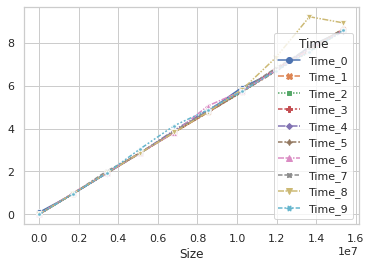

In [13]:
sns.lineplot(data=df, markers=True);

In [14]:
plt.savefig(f'{output}/{label}-line.png');
plt.savefig(f'{output}/{label}-line.pdf');

<Figure size 432x288 with 0 Axes>

In [15]:
dfs = df.stack().reset_index()
dfs = dfs.set_index('Size')
dfs = dfs.drop(columns=['Time'])
dfs = dfs.rename(columns={0:'Time'})
dfs

,Time
Size,
10,0.090
10,0.001
10,0.000
10,0.002
10,0.001
...,...
15360000,8.653
15360000,8.593
15360000,8.603


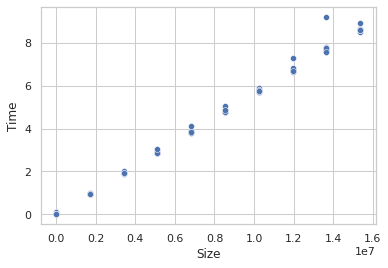

In [16]:
sns.scatterplot(data=dfs, x="Size", y="Time");
plt.savefig(f"{output}/{label}-scatter.pdf")
plt.savefig(f"{output}/{label}-scatter.png")

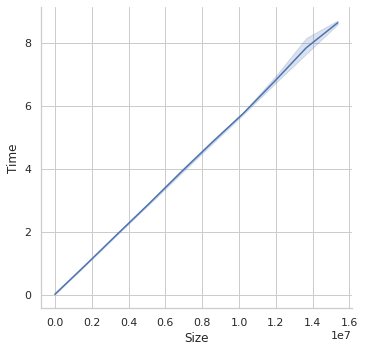

In [17]:
sns.relplot(x="Size", y="Time", kind="line", data=dfs);
plt.savefig(f"{output}/{label}-relplot.pdf")
plt.savefig(f"{output}/{label}-relplot.png")

In [18]:
df.to_pickle(f"{output}/{label}-df.pkl")